In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# train.json 파일을 읽어 데이터 프레임으로 만들기 
root = "../../dataset/"

with open(root + "train.json") as f:
    train = json.load(f)

categories = pd.DataFrame(train['categories'])
ann_df = pd.DataFrame(train['annotations'])
img_df = pd.DataFrame(train['images'])

# annotation 데이터 프레임에 image_id를 기준으로 file_name을 추가하기
ann_df['file_name'] = ann_df['image_id'].map(img_df['file_name'])

In [3]:
train.keys()

dict_keys(['info', 'licenses', 'images', 'categories', 'annotations'])

In [4]:
# images 정보
train['images'][0].keys()

dict_keys(['width', 'height', 'file_name', 'license', 'flickr_url', 'coco_url', 'date_captured', 'id'])

In [5]:
# annotations 정보
train['annotations'][0].keys()

dict_keys(['image_id', 'category_id', 'area', 'bbox', 'iscrowd', 'id'])

In [6]:
print('{}개의 image'.format(len(train['images'])))
print('{}개의 category'.format(len(train['categories'])))
print('{}개의 annotation'.format(len(train['annotations'])))

4883개의 image
10개의 category
23144개의 annotation


In [7]:
class_name = categories['name'].unique()
print(f'쓰레기 종류: {class_name}')

쓰레기 종류: ['General trash' 'Paper' 'Paper pack' 'Metal' 'Glass' 'Plastic'
 'Styrofoam' 'Plastic bag' 'Battery' 'Clothing']


In [8]:
ann_df.head(10)

image_id  category_id       area                          bbox  iscrowd  \
0         0            0  257301.66  [197.6, 193.7, 547.8, 469.7]        0   
1         1            3   10402.56     [0.0, 407.4, 57.6, 180.6]        0   
2         1            7   26259.36    [0.0, 455.6, 144.6, 181.6]        0   
3         1            4   69096.17  [722.3, 313.4, 274.3, 251.9]        0   
4         1            5   24164.58  [353.2, 671.0, 233.7, 103.4]        0   
5         1            5  188324.40    [3.7, 448.5, 778.2, 242.0]        0   
6         1            0   38908.72  [425.3, 681.9, 216.4, 179.8]        0   
7         1            7    7391.52    [92.4, 601.7, 139.2, 53.1]        0   
8         1            0    6857.76    [622.4, 686.5, 72.8, 94.2]        0   
9         2            3  324010.80  [267.9, 165.2, 631.6, 513.0]        0   

   id       file_name  
0   0  train/0000.jpg  
1   1  train/0001.jpg  
2   2  train/0001.jpg  
3   3  train/0001.jpg  
4   4  train/0001.jpg  
5   5  train/0001.jpg  
6   6  train/0001.jpg  
7   7  train/0001.jpg  
8   8  train/0001.jpg  
9   9  train/0002.jpg

In [9]:
# 각 이미지별로 몇개의 bbox가 있는지 확인
ann_df['image_id'].value_counts().describe()

count    4883.000000
mean        4.739709
std         6.355155
min         1.000000
25%         1.000000
50%         2.000000
75%         6.000000
max        71.000000
Name: image_id, dtype: float64

In [10]:
# 각 카테고리별로 몇개의 bbox가 있는지 확인
ann_df['category_id'].value_counts()

1    6352
7    5178
0    3966
5    2943
6    1263
4     982
3     936
2     897
9     468
8     159
Name: category_id, dtype: int64

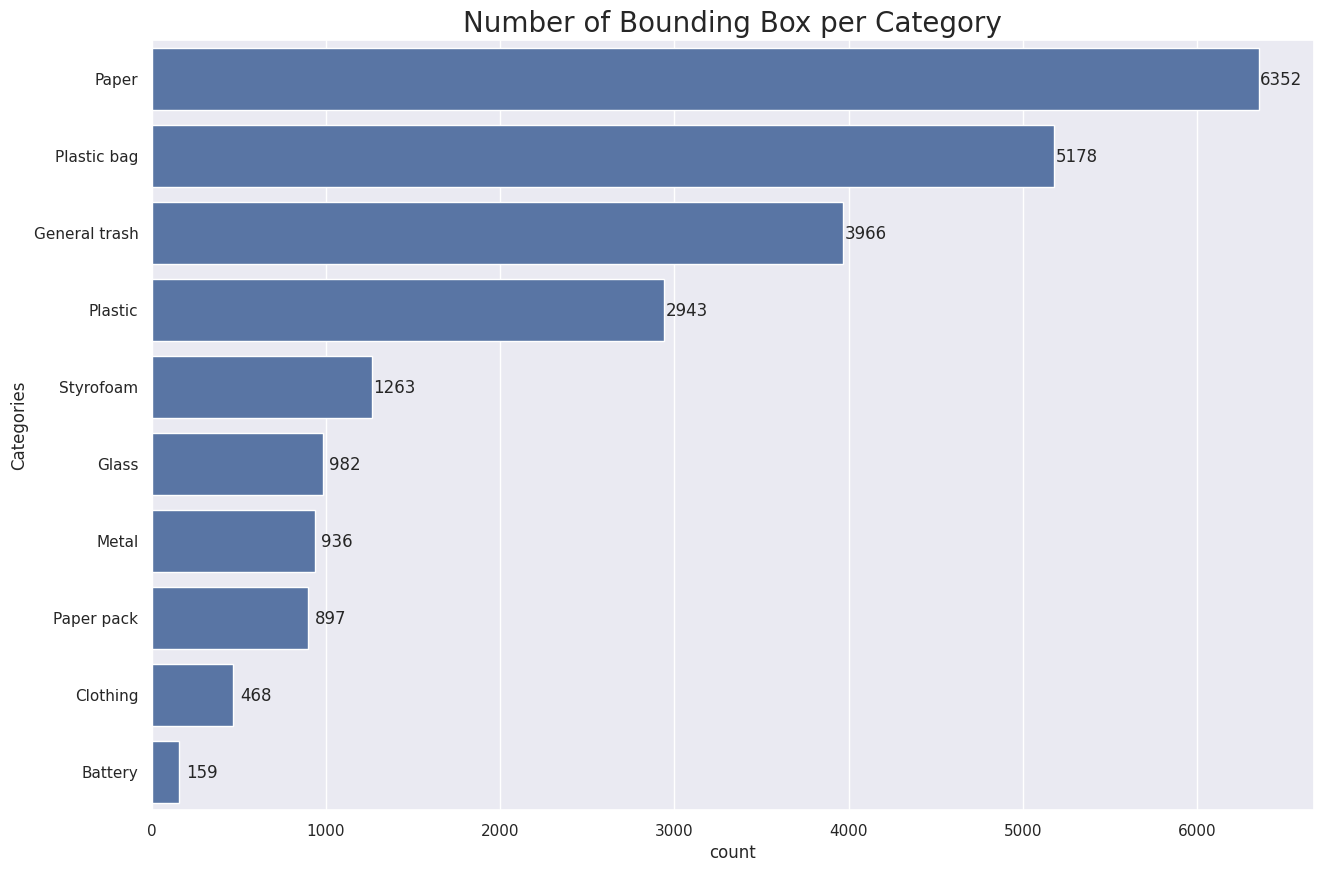

In [11]:
# 각 카테고리별로 몇개의 bbox가 있는지 시각화
sns.set(rc={'figure.figsize':(15,10)})
ctgr_bbox_df = pd.concat([ann_df['image_id'], ann_df['category_id']], axis=1)

ctgr_bbox_df['Categories'] = ctgr_bbox_df['category_id'].map(categories['name'])

bat_plot = sns.countplot(y='Categories', 
                         data=ctgr_bbox_df, 
                         order=ctgr_bbox_df['Categories'].value_counts().index)
bat_plot.set_title('Number of Bounding Box per Category', fontsize=20)

for i, p in enumerate(bat_plot.patches):
    bat_plot.annotate(ctgr_bbox_df['Categories'].value_counts()[i], 
                      (p.get_x()+p.get_width()+50, p.get_y()+0.6), 
                      ha='center', 
                      va='center', 
                      xytext=(10, 10), 
                      textcoords='offset points')

In [12]:
from PIL import Image, ImageDraw

In [13]:
# 제일 큰 bbox와 제일 작은 bbox, 그리고 평균 bbox의 크기를 확인
print(f'max area: {ann_df.area.max()} \
      \nmin area: {ann_df.area.min()} \
      \nmean area: {ann_df.area.mean()}\n')

max area: 1048371.21       
min area: 0.56       
mean area: 92863.95783831662



In [14]:
# 제일 큰 bbox와 제일 작은 bbox를 가진 이미지의 정보
ann_df[ann_df['area'].isin([ann_df.area.max(), ann_df.area.min()])]

image_id  category_id        area                        bbox  iscrowd  \
5159      1063            0        0.56    [647.8, 460.2, 0.7, 0.8]        0   
5565      1160            7  1048371.21  [0.0, 0.0, 1023.9, 1023.9]        0   

        id       file_name  
5159  5159  train/1063.jpg  
5565  5565  train/1160.jpg

In [15]:
# bbox를 그리기 위한 색 리스트
# General trash, Paper, Paper pack, Metal, Glass, Plastic, Styrofoam, Plastic bag, Battery, Clothing
colors = ['yellow', 'blue', 'green', 'red', 'orange', 'magenta', 'pink', 'cyan', 'gray', 'olive']

In [26]:
def draw_bbox(img_id, lt = 500, gt = 1000000, all = False,):
    '''
    img_id: 이미지 id
    lt: 크기가 lt이하인 bbox 그리기
    gt: 크기가 gt이상인 bbox 그리기
    all: True일 경우 모든 bbox를 그리고 False일 경우 lt와 gt에 해당하는 bbox만 그리기
    '''

    img = Image.open(root + ann_df[ann_df['image_id'] == img_id]['file_name'].values[0])
    draw_df = ann_df[ann_df['image_id'] == img_id].drop(['image_id', 'id', 'iscrowd', 'file_name'], axis=1)

    print(f"\n{img_id}번 이미지 category별로 bbox개수 확인\n", draw_df.groupby('category_id').count())

    # 제일 작은 박스가 위로 오도록 정렬
    draw_df.sort_values(by='bbox', inplace=True)    

    for i, (category, (x_min, y_min, w, h)) in enumerate(zip(draw_df['category_id'], draw_df['bbox'])):
        if all: # 모든 bbox를 그리기
            draw = ImageDraw.Draw(img, "RGBA")
            draw.rectangle([(x_min, y_min), 
                            (x_min+w, y_min+h)], 
                            outline=colors[category], 
                            width=3,
                            fill=(0, 0, 0, 50))
        elif draw_df['area'].values[i] <= lt or draw_df['area'].values[i] >= gt: # bbox의 크기가 lt보다 작거나 gt보다 큰 경우만 그리기
            draw = ImageDraw.Draw(img, "RGBA")
            draw.rectangle([(x_min, y_min), 
                            (x_min+w, y_min+h)], 
                            outline=colors[category], 
                            width=3,
                            fill=(0, 0, 0, 50))
    img.show(img)


1063번 이미지 category별로 bbox개수 확인
              area  bbox
category_id            
0               2     2
1               3     3
2               2     2
3               1     1
5               9     9
7               9     9


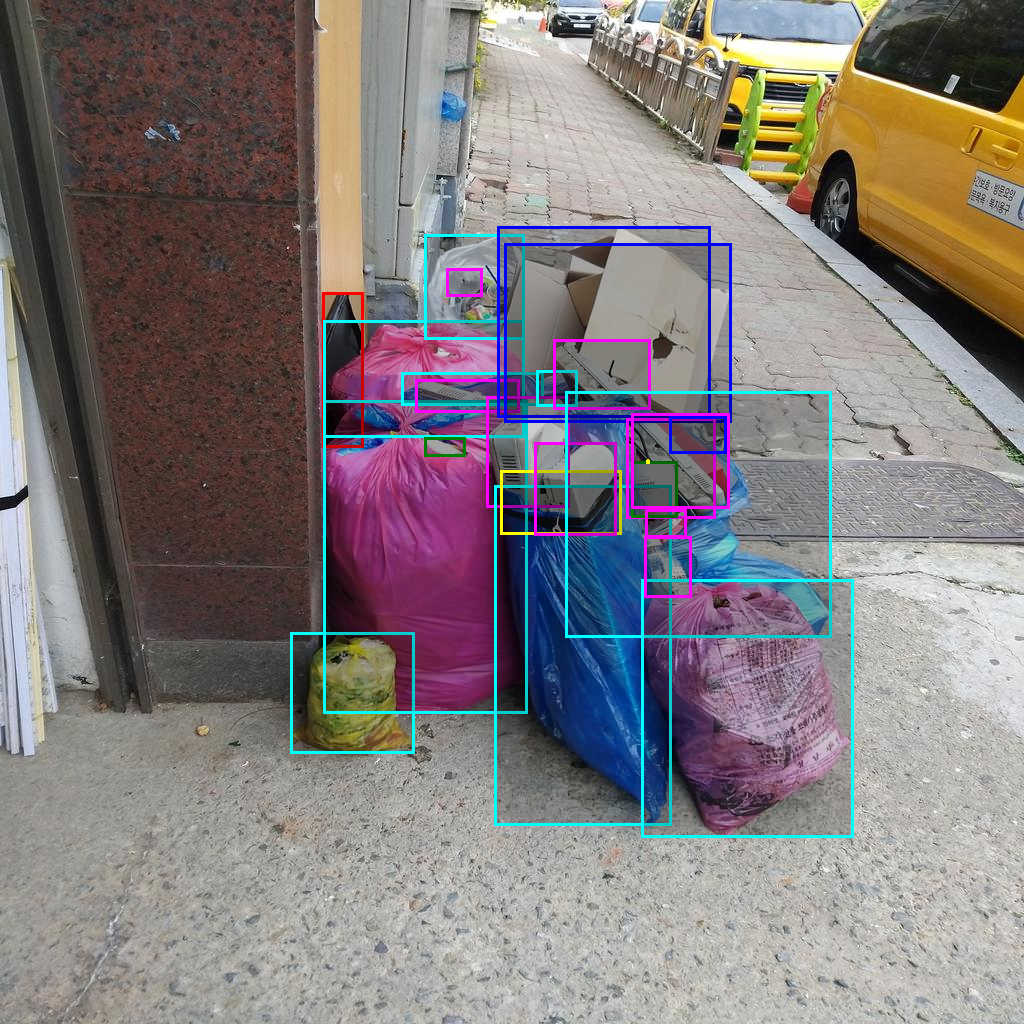


1160번 이미지 category별로 bbox개수 확인
              area  bbox
category_id            
0               1     1
7               4     4


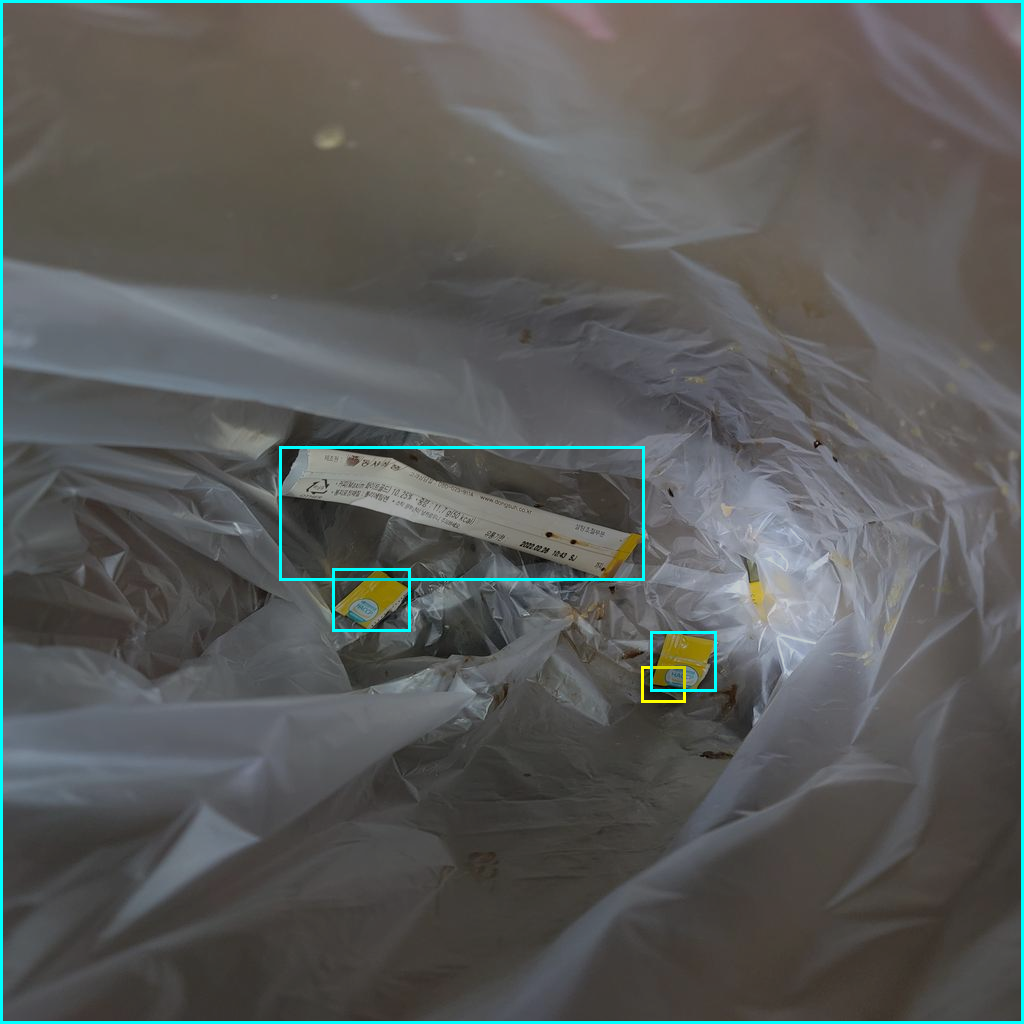

In [27]:
# 제일 작은 bbox를 가진 이미지와 제일 큰 bbox를 가진 이미지를 bbox를 함께 시각화
for idx in [1063, 1160]:
    draw_bbox(idx, 500, 1000000, True)

In [129]:
# bbox의 크기가 500보다 작은 이미지들의 정보
ann_df[ann_df['area'] < 500].sort_values(by='area')

image_id  category_id    area                         bbox  iscrowd  \
5159       1063            0    0.56     [647.8, 460.2, 0.7, 0.8]        0   
6539       1377            1    3.12     [719.8, 604.7, 1.3, 2.4]        0   
17594      3712            2   66.25    [883.8, 638.5, 12.5, 5.3]        0   
5067       1056            5  105.08     [530.6, 70.9, 14.2, 7.4]        0   
7227       1521            3  275.12    [728.4, 307.8, 36.2, 7.6]        0   
12473      2630            7  301.71    [570.2, 822.5, 8.9, 33.9]        0   
17780      3756            0  318.16    [749.0, 282.4, 9.7, 32.8]        0   
4813       1002            5  324.36      [0.0, 35.6, 10.2, 31.8]        0   
18091      3817            1  347.70   [721.0, 816.1, 18.3, 19.0]        0   
760         160            0  350.00   [633.2, 694.1, 20.0, 17.5]        0   
2905        624            1  354.57   [659.6, 569.6, 22.3, 15.9]        0   
20511      4313            0  363.72    [606.0, 201.1, 8.4, 43.3]        0   
13598      2902            5  365.65     [419.0, 51.1, 7.1, 51.5]        0   
12073      2556            0  374.42    [309.2, 741.1, 38.6, 9.7]        0   
3905        824            5  387.35  [1011.0, 464.9, 12.7, 30.5]        0   
7226       1521            3  397.83    [743.3, 284.7, 44.7, 8.9]        0   
1977        394            3  412.83   [907.9, 341.1, 13.9, 29.7]        0   
18300      3850            5  426.40   [288.8, 218.4, 41.0, 10.4]        0   
9307       1955            0  436.76   [127.3, 109.2, 12.2, 35.8]        0   
19293      4071            0  438.60   [115.8, 544.0, 43.0, 10.2]        0   
1524        298            7  441.15   [1015.4, 802.4, 8.5, 51.9]        0   
19859      4197            0  442.68    [80.3, 583.6, 37.2, 11.9]        0   
19831      4195            0  443.65    [342.7, 440.1, 9.5, 46.7]        0   
8021       1700            1  455.92    [19.0, 119.1, 13.9, 32.8]        0   
12515      2639            0  461.02    [790.3, 459.5, 8.9, 51.8]        0   
5883       1232            1  475.38   [560.3, 670.1, 11.4, 41.7]        0   
6790       1426            0  478.24    [358.6, 190.2, 9.8, 48.8]        0   
19244      4062            1  483.14   [635.4, 471.2, 40.6, 11.9]        0   

          id       file_name  
5159    5159  train/1063.jpg  
6539    6539  train/1377.jpg  
17594  17594  train/3712.jpg  
5067    5067  train/1056.jpg  
7227    7227  train/1521.jpg  
12473  12473  train/2630.jpg  
17780  17780  train/3756.jpg  
4813    4813  train/1002.jpg  
18091  18091  train/3817.jpg  
760      760  train/0160.jpg  
2905    2905  train/0624.jpg  
20511  20511  train/4313.jpg  
13598  13598  train/2902.jpg  
12073  12073  train/2556.jpg  
3905    3905  train/0824.jpg  
7226    7226  train/1521.jpg  
1977    1977  train/0394.jpg  
18300  18300  train/3850.jpg  
9307    9307  train/1955.jpg  
19293  19293  train/4071.jpg  
1524    1524  train/0298.jpg  
19859  19859  train/4197.jpg  
19831  19831  train/4195.jpg  
8021    8021  train/1700.jpg  
12515  12515  train/2639.jpg  
5883    5883  train/1232.jpg  
6790    6790  train/1426.jpg  
19244  19244  train/4062.jpg


1377번 이미지 category별로 bbox개수 확인
              area  bbox
category_id            
0               1     1
1               1     1
7               3     3


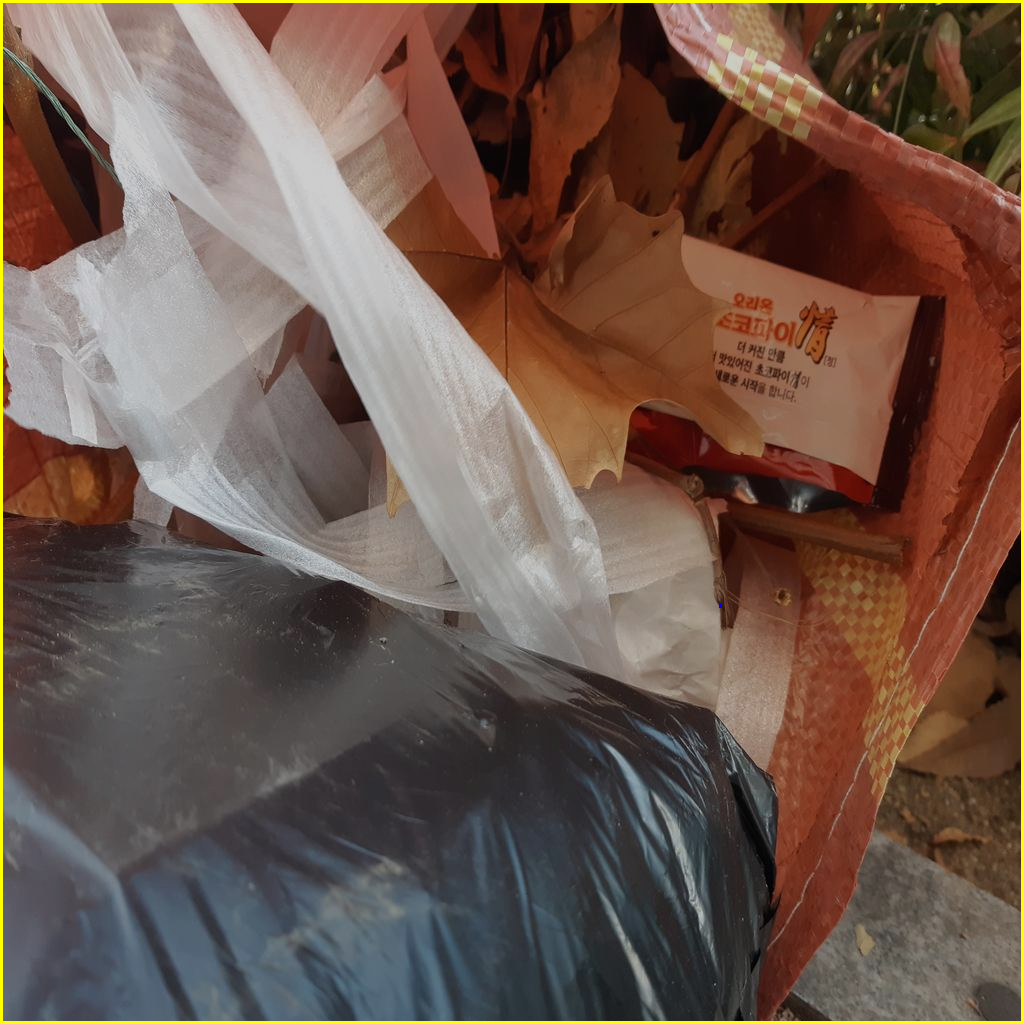

In [29]:
# area가 3.12인 bbox를 가진 이미지 시각화
draw_bbox(1377, 500, 1000000)


3712번 이미지 category별로 bbox개수 확인
              area  bbox
category_id            
0               1     1
2               2     2
6               2     2
7               5     5


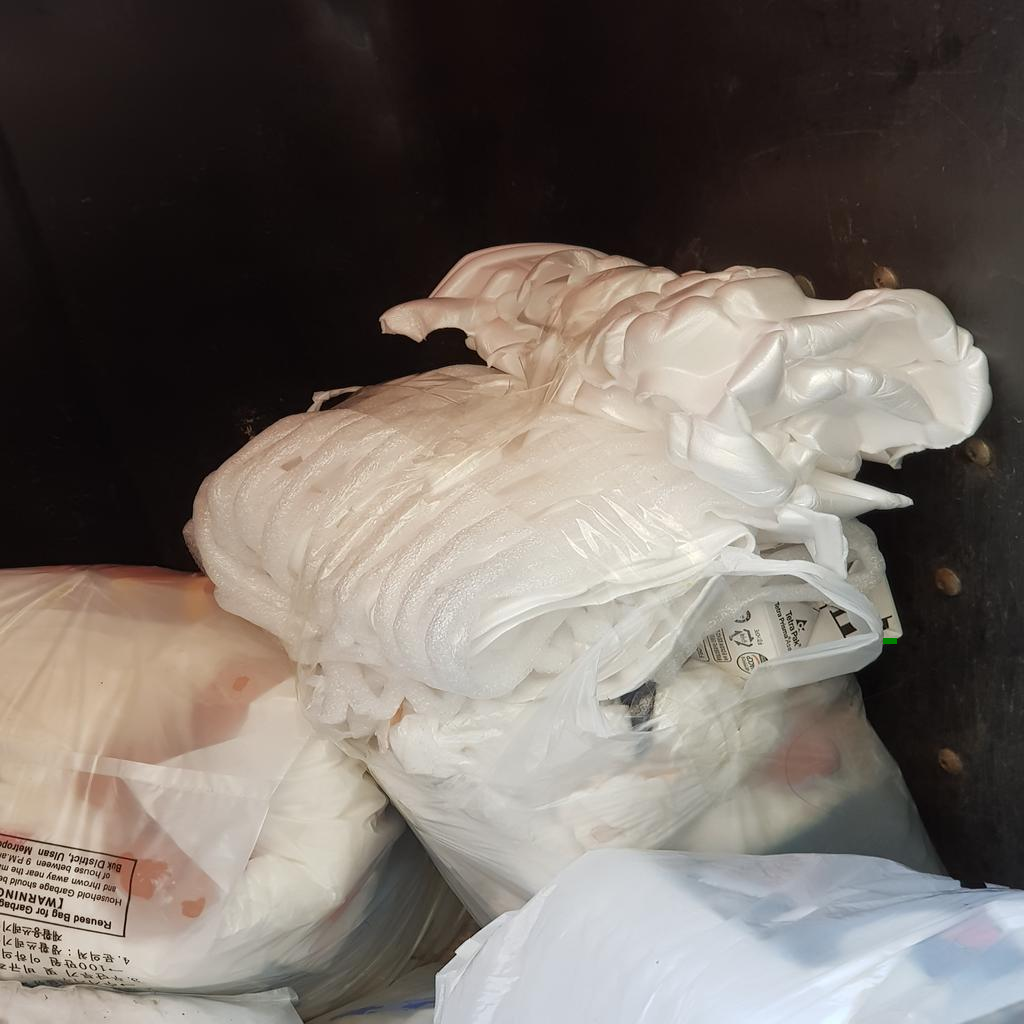

In [30]:
# area가 66.25인 bbox를 가진 이미지 시각화
draw_bbox(3712, 500, 1000000)

In [132]:
# bbox의 크기가 1000,000보다 큰 이미지들의 정보
ann_df[ann_df['area'] > 1000000].sort_values(by='area', ascending=False)

image_id  category_id        area                         bbox  \
5565       1160            7  1048371.21   [0.0, 0.0, 1023.9, 1023.9]   
23048      4857            0  1048064.06   [0.0, 0.0, 1023.8, 1023.7]   
4272        901            7  1048064.06   [0.0, 0.0, 1023.7, 1023.8]   
10443      2194            0  1048064.06   [0.0, 0.0, 1023.8, 1023.7]   
7810       1667            0  1048064.06   [0.0, 0.0, 1023.8, 1023.7]   
20006      4220            0  1048064.06   [0.0, 0.0, 1023.7, 1023.8]   
11449      2422            0  1048064.06   [0.0, 0.0, 1023.7, 1023.8]   
6537       1377            0  1048064.06   [0.0, 0.0, 1023.8, 1023.7]   
15633      3289            1  1048064.06   [0.0, 0.0, 1023.8, 1023.7]   
11441      2419            1  1047961.69   [0.0, 0.0, 1023.7, 1023.7]   
13337      2841            0  1047961.69   [0.0, 0.0, 1023.7, 1023.7]   
13835      2948            0  1047961.69   [0.0, 0.0, 1023.7, 1023.7]   
13868      2950            0  1047961.69   [0.0, 0.0, 1023.7, 1023.7]   
14779      3118            1  1047961.69   [0.0, 0.0, 1023.7, 1023.7]   
14230      3007            7  1047961.69   [0.0, 0.0, 1023.7, 1023.7]   
789         165            0  1047961.69   [0.0, 0.0, 1023.7, 1023.7]   
15360      3237            1  1047961.69   [0.0, 0.0, 1023.7, 1023.7]   
15917      3353            0  1047961.69   [0.0, 0.0, 1023.7, 1023.7]   
18283      3850            0  1047961.69   [0.0, 0.0, 1023.7, 1023.7]   
19104      4041            1  1047961.69   [0.0, 0.0, 1023.7, 1023.7]   
19106      4041            1  1047961.69   [0.0, 0.0, 1023.7, 1023.7]   
20301      4269            0  1047961.69   [0.0, 0.0, 1023.7, 1023.7]   
20313      4271            7  1047961.69   [0.0, 0.0, 1023.7, 1023.7]   
22362      4725            7  1047961.69   [0.0, 0.0, 1023.7, 1023.7]   
9777       2040            1  1047961.69   [0.0, 0.0, 1023.7, 1023.7]   
480         108            7  1047961.69   [0.0, 0.0, 1023.7, 1023.7]   
9492       1991            1  1047961.69   [0.0, 0.0, 1023.7, 1023.7]   
4675        973            1  1047961.69   [0.0, 0.0, 1023.7, 1023.7]   
2748        591            0  1047961.69   [0.0, 0.0, 1023.7, 1023.7]   
2780        599            5  1047961.69   [0.0, 0.0, 1023.7, 1023.7]   
3154        673            7  1047961.69   [0.0, 0.0, 1023.7, 1023.7]   
7980       1687            7  1047961.69   [0.0, 0.0, 1023.7, 1023.7]   
3985        838            1  1047961.69   [0.0, 0.0, 1023.7, 1023.7]   
1615        313            0  1047961.69   [0.0, 0.0, 1023.7, 1023.7]   
4129        868            1  1047961.69   [0.0, 0.0, 1023.7, 1023.7]   
6061       1275            0  1047961.69   [0.0, 0.0, 1023.7, 1023.7]   
6848       1445            1  1047961.69   [0.0, 0.0, 1023.7, 1023.7]   
950         186            7  1047961.69   [0.0, 0.0, 1023.7, 1023.7]   
6917       1456            1  1047961.69   [0.0, 0.0, 1023.7, 1023.7]   
7904       1677            7  1047961.69   [0.0, 0.0, 1023.7, 1023.7]   
7907       1677            1  1047961.69   [0.0, 0.0, 1023.7, 1023.7]   
2684        574            9  1047961.69   [0.0, 0.0, 1023.7, 1023.7]   
14557      3068            7  1046221.40   [0.0, 0.0, 1023.7, 1022.0]   
966         190            5  1045914.29   [0.0, 0.0, 1021.7, 1023.7]   
9759       2039            5  1036086.77  [11.5, 0.0, 1012.1, 1023.7]   
19466      4111            9  1032196.71  [0.0, 15.5, 1023.7, 1008.3]   
2535        543            7  1030278.20   [0.0, 0.0, 1022.0, 1008.1]   
19324      4075            1  1024621.33   [0.0, 0.0, 1000.9, 1023.7]   
11935      2532            1  1022983.41    [0.0, 0.0, 1023.7, 999.3]   
3928        829            5  1020020.10   [27.0, 0.0, 996.6, 1023.5]   
3735        802            1  1009220.45    [0.0, 4.7, 990.5, 1018.9]   

       iscrowd     id       file_name  
5565         0   5565  train/1160.jpg  
23048        0  23048  train/4857.jpg  
4272         0   4272  train/0901.jpg  
10443        0  10443  train/2194.jpg  
7810      


802번 이미지 category별로 bbox개수 확인
              area  bbox
category_id            
1              15    15


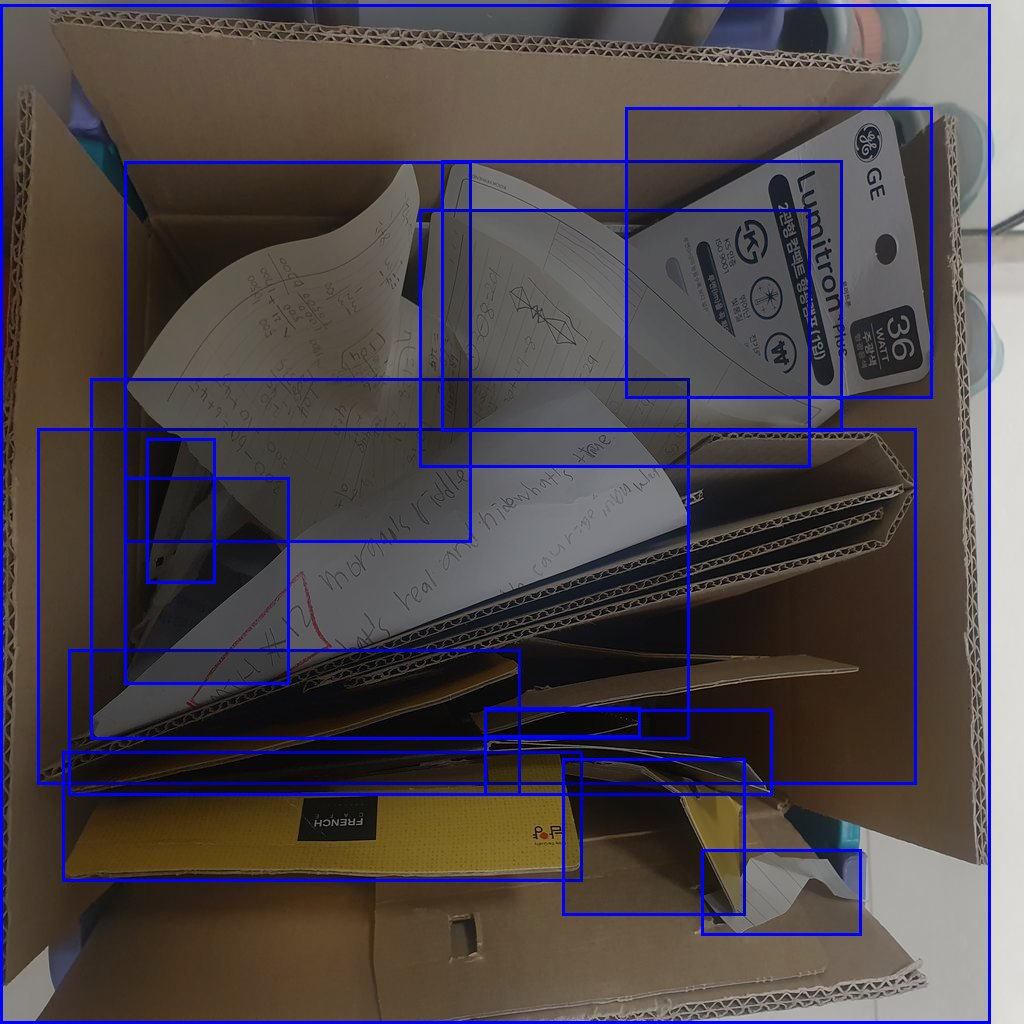

In [31]:
# area가 1,000,000보다 큰 bbox를 가진 이미지 시각화
draw_bbox(802, 500, 100000, True)

In [133]:
# Category별 bbox의 평균 크기를 확인
avg_area = pd.concat([pd.DataFrame({'Categories': class_name}), 
                      ann_df.groupby('category_id')['area'].mean()], axis=1)

avg_area.sort_values(by='area', ascending=False, inplace=True)
avg_area

Categories           area
9       Clothing  189349.355983
7    Plastic bag  110357.698233
6      Styrofoam   97589.452375
1          Paper   92044.196322
3          Metal   91644.378526
5        Plastic   80990.612409
0  General trash   78860.147368
2     Paper pack   76116.495072
4          Glass   69338.117495
8        Battery   50409.963711

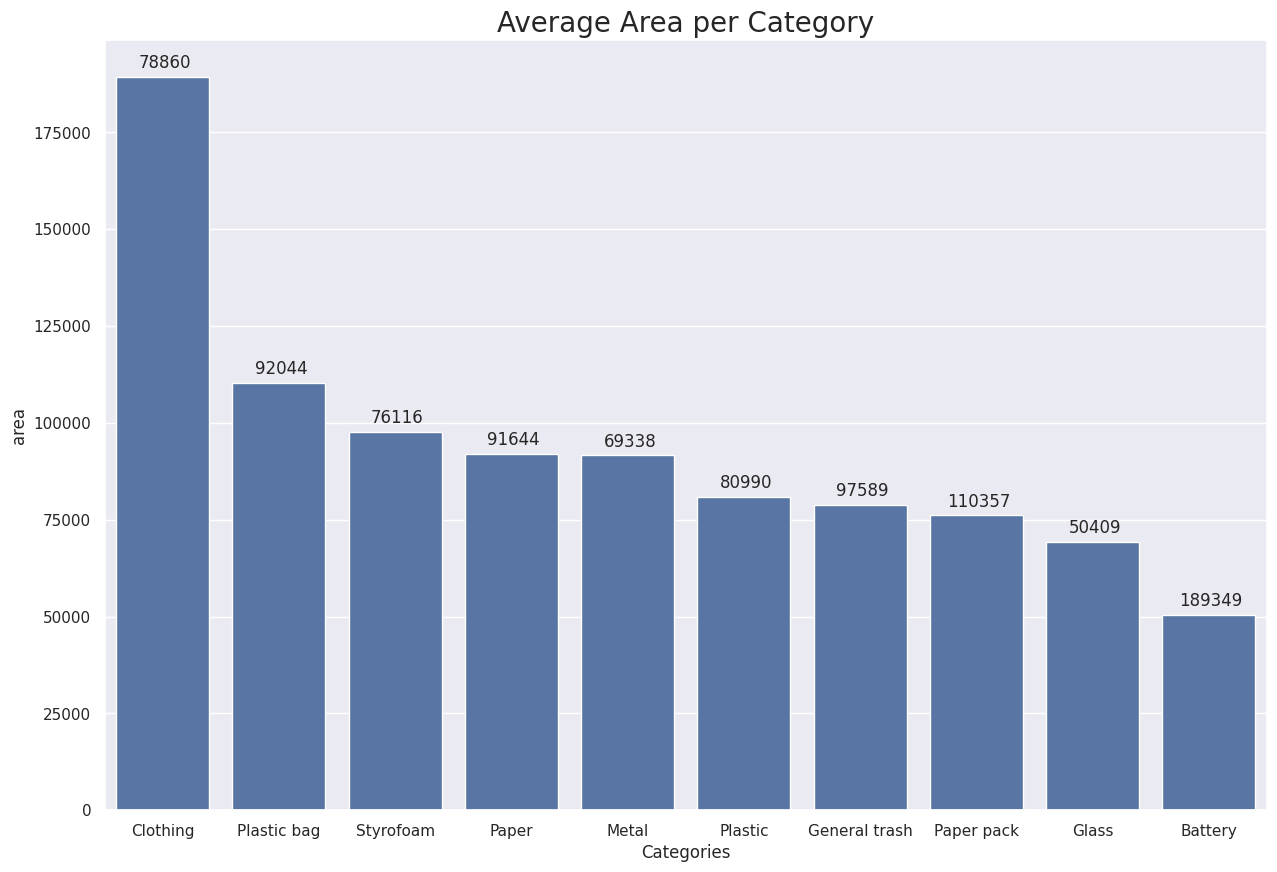

In [134]:
# 각 카테고리별로 bbox의 평균 넓이를 시각화
fig, ax = plt.subplots(figsize=(15,10))

barplot = sns.barplot(x='Categories', y='area', data=avg_area)
barplot.set_title('Average Area per Category', fontsize=20)

for i, p in enumerate(barplot.patches):
    barplot.annotate(int(avg_area['area'][i]), 
                      (p.get_x() + 0.3, p.get_y()+p.get_height()), 
                      ha='center', 
                      va='center', 
                      xytext=(10, 10), 
                      textcoords='offset points')